In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
num_classes = 7

In [4]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [7]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [8]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=num_classes)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=7, bias=True)
)

In [9]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

#dataset_str = 'cropped_images'
#dataset_str = 'cropped_processed_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'
#dataset_str = 'cropped_rotated_processed_images_3'
dataset_str = 'cropped_rotated_processed_images_4'

training_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=0)

testing_dataset = GuitarDataset(f'../chords_data/{dataset_str}', transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=10, shuffle=True, num_workers=0)

In [10]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [11]:
model = model.to(device)

In [12]:
results_dir = 'results/'

In [13]:
import csv
csv_header = ['Classification loss']

csvfile = open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [14]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 18 / 20 with accuracy 90.00
Got 24 / 30 with accuracy 80.00
Got 30 / 40 with accuracy 75.00
Got 37 / 50 with accuracy 74.00
Got 43 / 60 with accuracy 71.67
Got 48 / 70 with accuracy 68.57
Got 54 / 80 with accuracy 67.50
Got 60 / 90 with accuracy 66.67
Got 67 / 100 with accuracy 67.00
Got 75 / 110 with accuracy 68.18
Got 84 / 120 with accuracy 70.00
Got 91 / 130 with accuracy 70.00
Got 96 / 140 with accuracy 68.57
Got 102 / 150 with accuracy 68.00
Got 109 / 160 with accuracy 68.12
Got 113 / 170 with accuracy 66.47
Got 121 / 180 with accuracy 67.22
Got 129 / 190 with accuracy 67.89
Got 133 / 196 with accuracy 67.86
----------
Epoch 1/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 6 / 10 with accuracy 60.00
Got 12 / 20 with accuracy 60.00
Got 22 / 30 with accuracy 73.33
Got 30 / 40 with accuracy 75.00
Got 40 / 50 with accuracy 80.00
Got 48 / 60 with accuracy 80.00
Got 56 / 70 with accuracy 80.00
Got 64 / 80 with accuracy 80.00
Got 73 / 90 with accuracy 81.11
Got 82 / 100 with accuracy 82.00
Got 89 / 110 with accuracy 80.91
Got 93 / 120 with accuracy 77.50
Got 102 / 130 with accuracy 78.46
Got 109 / 140 with accuracy 77.86
Got 115 / 150 with accuracy 76.67
Got 122 / 160 with accuracy 76.25
Got 131 / 170 with accuracy 77.06
Got 139 / 180 with accuracy 77.22
Got 147 / 190 with accuracy 77.37
Got 153 / 196 with accuracy 78.06
----------
Epoch 2/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 14 / 20 with accuracy 70.00
Got 17 / 30 with accuracy 56.67
Got 23 / 40 with accuracy 57.50
Got 31 / 50 with accuracy 62.00
Got 39 / 60 with accuracy 65.00
Got 45 / 70 with accuracy 64.29
Got 53 / 80 with accuracy 66.25
Got 59 / 90 with accuracy 65.56
Got 67 / 100 with accuracy 67.00
Got 74 / 110 with accuracy 67.27
Got 82 / 120 with accuracy 68.33
Got 88 / 130 with accuracy 67.69
Got 93 / 140 with accuracy 66.43
Got 102 / 150 with accuracy 68.00
Got 109 / 160 with accuracy 68.12
Got 116 / 170 with accuracy 68.24
Got 124 / 180 with accuracy 68.89
Got 128 / 190 with accuracy 67.37
Got 133 / 196 with accuracy 67.86
----------
Epoch 3/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 15 / 20 with accuracy 75.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 42 / 50 with accuracy 84.00
Got 48 / 60 with accuracy 80.00
Got 55 / 70 with accuracy 78.57
Got 61 / 80 with accuracy 76.25
Got 69 / 90 with accuracy 76.67
Got 78 / 100 with accuracy 78.00
Got 83 / 110 with accuracy 75.45
Got 88 / 120 with accuracy 73.33
Got 96 / 130 with accuracy 73.85
Got 100 / 140 with accuracy 71.43
Got 109 / 150 with accuracy 72.67
Got 116 / 160 with accuracy 72.50
Got 124 / 170 with accuracy 72.94
Got 133 / 180 with accuracy 73.89
Got 141 / 190 with accuracy 74.21
Got 145 / 196 with accuracy 73.98
----------
Epoch 4/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 23 / 30 with accuracy 76.67
Got 32 / 40 with accuracy 80.00
Got 42 / 50 with accuracy 84.00
Got 50 / 60 with accuracy 83.33
Got 58 / 70 with accuracy 82.86
Got 66 / 80 with accuracy 82.50
Got 76 / 90 with accuracy 84.44
Got 86 / 100 with accuracy 86.00
Got 91 / 110 with accuracy 82.73
Got 99 / 120 with accuracy 82.50
Got 106 / 130 with accuracy 81.54
Got 116 / 140 with accuracy 82.86
Got 124 / 150 with accuracy 82.67
Got 133 / 160 with accuracy 83.12
Got 143 / 170 with accuracy 84.12
Got 150 / 180 with accuracy 83.33
Got 157 / 190 with accuracy 82.63
Got 163 / 196 with accuracy 83.16
----------
Epoch 5/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 16 / 20 with accuracy 80.00
Got 24 / 30 with accuracy 80.00
Got 32 / 40 with accuracy 80.00
Got 40 / 50 with accuracy 80.00
Got 49 / 60 with accuracy 81.67
Got 56 / 70 with accuracy 80.00
Got 65 / 80 with accuracy 81.25
Got 73 / 90 with accuracy 81.11
Got 83 / 100 with accuracy 83.00
Got 91 / 110 with accuracy 82.73
Got 101 / 120 with accuracy 84.17
Got 108 / 130 with accuracy 83.08
Got 115 / 140 with accuracy 82.14
Got 121 / 150 with accuracy 80.67
Got 129 / 160 with accuracy 80.62
Got 136 / 170 with accuracy 80.00
Got 144 / 180 with accuracy 80.00
Got 154 / 190 with accuracy 81.05
Got 160 / 196 with accuracy 81.63
----------
Epoch 6/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 18 / 20 with accuracy 90.00
Got 27 / 30 with accuracy 90.00
Got 37 / 40 with accuracy 92.50
Got 46 / 50 with accuracy 92.00
Got 53 / 60 with accuracy 88.33
Got 61 / 70 with accuracy 87.14
Got 70 / 80 with accuracy 87.50
Got 79 / 90 with accuracy 87.78
Got 88 / 100 with accuracy 88.00
Got 98 / 110 with accuracy 89.09
Got 108 / 120 with accuracy 90.00
Got 117 / 130 with accuracy 90.00
Got 127 / 140 with accuracy 90.71
Got 136 / 150 with accuracy 90.67
Got 144 / 160 with accuracy 90.00
Got 151 / 170 with accuracy 88.82
Got 159 / 180 with accuracy 88.33
Got 166 / 190 with accuracy 87.37
Got 171 / 196 with accuracy 87.24
----------
Epoch 7/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 14 / 20 with accuracy 70.00
Got 22 / 30 with accuracy 73.33
Got 30 / 40 with accuracy 75.00
Got 36 / 50 with accuracy 72.00
Got 42 / 60 with accuracy 70.00
Got 45 / 70 with accuracy 64.29
Got 52 / 80 with accuracy 65.00
Got 61 / 90 with accuracy 67.78
Got 71 / 100 with accuracy 71.00
Got 78 / 110 with accuracy 70.91
Got 87 / 120 with accuracy 72.50
Got 95 / 130 with accuracy 73.08
Got 103 / 140 with accuracy 73.57
Got 111 / 150 with accuracy 74.00
Got 120 / 160 with accuracy 75.00
Got 128 / 170 with accuracy 75.29
Got 137 / 180 with accuracy 76.11
Got 145 / 190 with accuracy 76.32
Got 151 / 196 with accuracy 77.04
----------
Epoch 8/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 15 / 20 with accuracy 75.00
Got 21 / 30 with accuracy 70.00
Got 29 / 40 with accuracy 72.50
Got 38 / 50 with accuracy 76.00
Got 48 / 60 with accuracy 80.00
Got 54 / 70 with accuracy 77.14
Got 63 / 80 with accuracy 78.75
Got 70 / 90 with accuracy 77.78
Got 77 / 100 with accuracy 77.00
Got 83 / 110 with accuracy 75.45
Got 91 / 120 with accuracy 75.83
Got 97 / 130 with accuracy 74.62
Got 103 / 140 with accuracy 73.57
Got 111 / 150 with accuracy 74.00
Got 118 / 160 with accuracy 73.75
Got 127 / 170 with accuracy 74.71
Got 132 / 180 with accuracy 73.33
Got 136 / 190 with accuracy 71.58
Got 139 / 196 with accuracy 70.92
----------
Epoch 9/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 14 / 20 with accuracy 70.00
Got 22 / 30 with accuracy 73.33
Got 31 / 40 with accuracy 77.50
Got 39 / 50 with accuracy 78.00
Got 48 / 60 with accuracy 80.00
Got 56 / 70 with accuracy 80.00
Got 66 / 80 with accuracy 82.50
Got 72 / 90 with accuracy 80.00
Got 82 / 100 with accuracy 82.00
Got 91 / 110 with accuracy 82.73
Got 99 / 120 with accuracy 82.50
Got 106 / 130 with accuracy 81.54
Got 113 / 140 with accuracy 80.71
Got 119 / 150 with accuracy 79.33
Got 128 / 160 with accuracy 80.00
Got 137 / 170 with accuracy 80.59
Got 143 / 180 with accuracy 79.44
Got 151 / 190 with accuracy 79.47
Got 156 / 196 with accuracy 79.59
----------
Epoch 10/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 17 / 20 with accuracy 85.00
Got 27 / 30 with accuracy 90.00
Got 33 / 40 with accuracy 82.50
Got 42 / 50 with accuracy 84.00
Got 49 / 60 with accuracy 81.67
Got 55 / 70 with accuracy 78.57
Got 62 / 80 with accuracy 77.50
Got 71 / 90 with accuracy 78.89
Got 81 / 100 with accuracy 81.00
Got 91 / 110 with accuracy 82.73
Got 99 / 120 with accuracy 82.50
Got 107 / 130 with accuracy 82.31
Got 113 / 140 with accuracy 80.71
Got 119 / 150 with accuracy 79.33
Got 127 / 160 with accuracy 79.38
Got 137 / 170 with accuracy 80.59
Got 146 / 180 with accuracy 81.11
Got 156 / 190 with accuracy 82.11
Got 160 / 196 with accuracy 81.63
----------
Epoch 11/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 18 / 20 with accuracy 90.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 45 / 50 with accuracy 90.00
Got 53 / 60 with accuracy 88.33
Got 61 / 70 with accuracy 87.14
Got 67 / 80 with accuracy 83.75
Got 76 / 90 with accuracy 84.44
Got 85 / 100 with accuracy 85.00
Got 95 / 110 with accuracy 86.36
Got 105 / 120 with accuracy 87.50
Got 115 / 130 with accuracy 88.46
Got 125 / 140 with accuracy 89.29
Got 135 / 150 with accuracy 90.00
Got 142 / 160 with accuracy 88.75
Got 148 / 170 with accuracy 87.06
Got 158 / 180 with accuracy 87.78
Got 166 / 190 with accuracy 87.37
Got 172 / 196 with accuracy 87.76
----------
Epoch 12/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 7 / 10 with accuracy 70.00
Got 14 / 20 with accuracy 70.00
Got 21 / 30 with accuracy 70.00
Got 29 / 40 with accuracy 72.50
Got 37 / 50 with accuracy 74.00
Got 47 / 60 with accuracy 78.33
Got 56 / 70 with accuracy 80.00
Got 64 / 80 with accuracy 80.00
Got 72 / 90 with accuracy 80.00
Got 80 / 100 with accuracy 80.00
Got 89 / 110 with accuracy 80.91
Got 98 / 120 with accuracy 81.67
Got 106 / 130 with accuracy 81.54
Got 115 / 140 with accuracy 82.14
Got 125 / 150 with accuracy 83.33
Got 132 / 160 with accuracy 82.50
Got 136 / 170 with accuracy 80.00
Got 143 / 180 with accuracy 79.44
Got 153 / 190 with accuracy 80.53
Got 158 / 196 with accuracy 80.61
----------
Epoch 13/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 15 / 20 with accuracy 75.00
Got 22 / 30 with accuracy 73.33
Got 31 / 40 with accuracy 77.50
Got 41 / 50 with accuracy 82.00
Got 50 / 60 with accuracy 83.33
Got 60 / 70 with accuracy 85.71
Got 68 / 80 with accuracy 85.00
Got 78 / 90 with accuracy 86.67
Got 88 / 100 with accuracy 88.00
Got 97 / 110 with accuracy 88.18
Got 105 / 120 with accuracy 87.50
Got 112 / 130 with accuracy 86.15
Got 120 / 140 with accuracy 85.71
Got 130 / 150 with accuracy 86.67
Got 135 / 160 with accuracy 84.38
Got 144 / 170 with accuracy 84.71
Got 153 / 180 with accuracy 85.00
Got 162 / 190 with accuracy 85.26
Got 168 / 196 with accuracy 85.71
----------
Epoch 14/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 9 / 10 with accuracy 90.00
Got 17 / 20 with accuracy 85.00
Got 23 / 30 with accuracy 76.67
Got 33 / 40 with accuracy 82.50
Got 41 / 50 with accuracy 82.00
Got 51 / 60 with accuracy 85.00
Got 58 / 70 with accuracy 82.86
Got 68 / 80 with accuracy 85.00
Got 77 / 90 with accuracy 85.56
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 104 / 120 with accuracy 86.67
Got 111 / 130 with accuracy 85.38
Got 120 / 140 with accuracy 85.71
Got 128 / 150 with accuracy 85.33
Got 137 / 160 with accuracy 85.62
Got 147 / 170 with accuracy 86.47
Got 156 / 180 with accuracy 86.67
Got 165 / 190 with accuracy 86.84
Got 170 / 196 with accuracy 86.73
----------
Epoch 15/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 17 / 20 with accuracy 85.00
Got 26 / 30 with accuracy 86.67
Got 33 / 40 with accuracy 82.50
Got 42 / 50 with accuracy 84.00
Got 51 / 60 with accuracy 85.00
Got 59 / 70 with accuracy 84.29
Got 66 / 80 with accuracy 82.50
Got 76 / 90 with accuracy 84.44
Got 86 / 100 with accuracy 86.00
Got 95 / 110 with accuracy 86.36
Got 103 / 120 with accuracy 85.83
Got 109 / 130 with accuracy 83.85
Got 118 / 140 with accuracy 84.29
Got 126 / 150 with accuracy 84.00
Got 136 / 160 with accuracy 85.00
Got 144 / 170 with accuracy 84.71
Got 151 / 180 with accuracy 83.89
Got 161 / 190 with accuracy 84.74
Got 166 / 196 with accuracy 84.69
----------
Epoch 16/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 28 / 30 with accuracy 93.33
Got 37 / 40 with accuracy 92.50
Got 44 / 50 with accuracy 88.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 72 / 80 with accuracy 90.00
Got 79 / 90 with accuracy 87.78
Got 89 / 100 with accuracy 89.00
Got 98 / 110 with accuracy 89.09
Got 106 / 120 with accuracy 88.33
Got 114 / 130 with accuracy 87.69
Got 123 / 140 with accuracy 87.86
Got 131 / 150 with accuracy 87.33
Got 139 / 160 with accuracy 86.88
Got 147 / 170 with accuracy 86.47
Got 156 / 180 with accuracy 86.67
Got 164 / 190 with accuracy 86.32
Got 170 / 196 with accuracy 86.73
----------
Epoch 17/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 8 / 10 with accuracy 80.00
Got 16 / 20 with accuracy 80.00
Got 25 / 30 with accuracy 83.33
Got 34 / 40 with accuracy 85.00
Got 41 / 50 with accuracy 82.00
Got 48 / 60 with accuracy 80.00
Got 53 / 70 with accuracy 75.71
Got 61 / 80 with accuracy 76.25
Got 71 / 90 with accuracy 78.89
Got 80 / 100 with accuracy 80.00
Got 90 / 110 with accuracy 81.82
Got 100 / 120 with accuracy 83.33
Got 109 / 130 with accuracy 83.85
Got 119 / 140 with accuracy 85.00
Got 125 / 150 with accuracy 83.33
Got 133 / 160 with accuracy 83.12
Got 141 / 170 with accuracy 82.94
Got 150 / 180 with accuracy 83.33
Got 156 / 190 with accuracy 82.11
Got 161 / 196 with accuracy 82.14
----------
Epoch 18/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 19 / 20 with accuracy 95.00
Got 29 / 30 with accuracy 96.67
Got 39 / 40 with accuracy 97.50
Got 48 / 50 with accuracy 96.00
Got 58 / 60 with accuracy 96.67
Got 66 / 70 with accuracy 94.29
Got 74 / 80 with accuracy 92.50
Got 82 / 90 with accuracy 91.11
Got 91 / 100 with accuracy 91.00
Got 100 / 110 with accuracy 90.91
Got 109 / 120 with accuracy 90.83
Got 119 / 130 with accuracy 91.54
Got 127 / 140 with accuracy 90.71
Got 135 / 150 with accuracy 90.00
Got 144 / 160 with accuracy 90.00
Got 152 / 170 with accuracy 89.41
Got 159 / 180 with accuracy 88.33
Got 167 / 190 with accuracy 87.89
Got 170 / 196 with accuracy 86.73
----------
Epoch 19/19


  0%|          | 0/79 [00:00<?, ?it/s]

Got 10 / 10 with accuracy 100.00
Got 20 / 20 with accuracy 100.00
Got 29 / 30 with accuracy 96.67
Got 37 / 40 with accuracy 92.50
Got 45 / 50 with accuracy 90.00
Got 53 / 60 with accuracy 88.33
Got 62 / 70 with accuracy 88.57
Got 70 / 80 with accuracy 87.50
Got 79 / 90 with accuracy 87.78
Got 87 / 100 with accuracy 87.00
Got 97 / 110 with accuracy 88.18
Got 107 / 120 with accuracy 89.17
Got 116 / 130 with accuracy 89.23
Got 126 / 140 with accuracy 90.00
Got 135 / 150 with accuracy 90.00
Got 143 / 160 with accuracy 89.38
Got 150 / 170 with accuracy 88.24
Got 160 / 180 with accuracy 88.89
Got 169 / 190 with accuracy 88.95
Got 173 / 196 with accuracy 88.27


In [15]:
csvfile.close()

In [16]:
best_acc

88.26530612244898

In [17]:
torch.save(best_model_wts, f'salvataggi_pytorch/{dataset_str}_model_state_dict')

In [18]:
model.load_state_dict(torch.load(f'salvataggi_pytorch/{dataset_str}_model_state_dict'))
model.to(torch.device('cpu'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [19]:
testloader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True, num_workers=0)

In [20]:
dataiter = iter(testloader)
x, y = next(dataiter)
scores = model(x)
predictions = scores.argmax(1)

In [21]:
predictions

tensor([4, 3, 2, 3, 3, 5, 6, 2, 1, 6, 1, 5, 0, 0, 2, 6, 3, 5, 5, 2, 6, 2, 3, 5,
        2, 1, 5, 5, 3, 1, 3, 2, 4, 5, 4, 5, 1, 4, 0, 1, 0, 1, 2, 0, 3, 4, 5, 6,
        1, 1, 6, 1, 0, 1, 0, 2, 3, 2, 5, 6, 3, 5, 5, 5, 4, 0, 3, 5, 6, 2, 0, 5,
        3, 0, 1, 5, 5, 0, 5, 5, 4, 5, 3, 6, 0, 0, 3, 0, 5, 4, 2, 3, 5, 1, 2, 5,
        0, 1, 5, 1, 4, 1, 3, 0, 2, 3, 6, 3, 2, 6, 2, 0, 5, 3, 0, 2, 1, 1, 2, 3,
        3, 0, 4, 6, 5, 0, 1, 6, 4, 1, 5, 5, 5, 6, 4, 4, 1, 0, 1, 5, 3, 2, 5, 1,
        5, 4, 5, 2, 4, 1, 6, 3, 4, 5, 1, 2, 3, 5, 6, 4, 0, 3, 5, 0, 2, 2, 2, 1,
        0, 4, 2, 5, 0, 4, 1, 5, 2, 6, 4, 2, 3, 6, 6, 5, 2, 6, 6, 2, 3, 5, 3, 5,
        4, 1, 2, 0])

In [22]:
y

tensor([4, 3, 2, 3, 3, 5, 6, 2, 1, 6, 1, 5, 0, 0, 2, 6, 3, 5, 5, 2, 6, 2, 3, 5,
        2, 1, 5, 5, 4, 1, 3, 2, 4, 5, 4, 5, 1, 4, 0, 1, 0, 1, 2, 4, 1, 4, 5, 6,
        1, 1, 1, 1, 0, 1, 0, 2, 3, 2, 5, 6, 3, 3, 5, 4, 4, 0, 3, 1, 6, 0, 0, 5,
        3, 0, 1, 5, 5, 5, 1, 5, 4, 5, 3, 6, 0, 0, 3, 0, 5, 4, 2, 3, 5, 1, 2, 0,
        0, 1, 3, 1, 4, 1, 3, 1, 2, 3, 6, 3, 2, 6, 2, 0, 5, 3, 0, 2, 1, 1, 2, 3,
        3, 0, 4, 6, 5, 3, 1, 6, 4, 1, 5, 5, 6, 6, 4, 0, 1, 3, 1, 3, 3, 2, 1, 1,
        5, 4, 5, 2, 4, 1, 6, 3, 4, 5, 1, 2, 3, 1, 6, 4, 0, 3, 5, 0, 2, 6, 2, 1,
        0, 4, 3, 5, 3, 4, 1, 5, 2, 6, 4, 2, 3, 6, 6, 5, 2, 6, 6, 2, 3, 5, 3, 5,
        4, 1, 2, 0])

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame({'predictions': predictions.cpu().numpy(), 'y_true': y.cpu().numpy()})
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,4,4
1,3,3
2,2,2
3,3,3
4,3,3
...,...,...
191,5,5
192,4,4
193,1,1
194,2,2


In [25]:
preds = df['predictions'].values
preds

array([4, 3, 2, 3, 3, 5, 6, 2, 1, 6, 1, 5, 0, 0, 2, 6, 3, 5, 5, 2, 6, 2,
       3, 5, 2, 1, 5, 5, 3, 1, 3, 2, 4, 5, 4, 5, 1, 4, 0, 1, 0, 1, 2, 0,
       3, 4, 5, 6, 1, 1, 6, 1, 0, 1, 0, 2, 3, 2, 5, 6, 3, 5, 5, 5, 4, 0,
       3, 5, 6, 2, 0, 5, 3, 0, 1, 5, 5, 0, 5, 5, 4, 5, 3, 6, 0, 0, 3, 0,
       5, 4, 2, 3, 5, 1, 2, 5, 0, 1, 5, 1, 4, 1, 3, 0, 2, 3, 6, 3, 2, 6,
       2, 0, 5, 3, 0, 2, 1, 1, 2, 3, 3, 0, 4, 6, 5, 0, 1, 6, 4, 1, 5, 5,
       5, 6, 4, 4, 1, 0, 1, 5, 3, 2, 5, 1, 5, 4, 5, 2, 4, 1, 6, 3, 4, 5,
       1, 2, 3, 5, 6, 4, 0, 3, 5, 0, 2, 2, 2, 1, 0, 4, 2, 5, 0, 4, 1, 5,
       2, 6, 4, 2, 3, 6, 6, 5, 2, 6, 6, 2, 3, 5, 3, 5, 4, 1, 2, 0],
      dtype=int64)

In [26]:
y_true = df['y_true'].values
y_true

array([4, 3, 2, 3, 3, 5, 6, 2, 1, 6, 1, 5, 0, 0, 2, 6, 3, 5, 5, 2, 6, 2,
       3, 5, 2, 1, 5, 5, 4, 1, 3, 2, 4, 5, 4, 5, 1, 4, 0, 1, 0, 1, 2, 4,
       1, 4, 5, 6, 1, 1, 1, 1, 0, 1, 0, 2, 3, 2, 5, 6, 3, 3, 5, 4, 4, 0,
       3, 1, 6, 0, 0, 5, 3, 0, 1, 5, 5, 5, 1, 5, 4, 5, 3, 6, 0, 0, 3, 0,
       5, 4, 2, 3, 5, 1, 2, 0, 0, 1, 3, 1, 4, 1, 3, 1, 2, 3, 6, 3, 2, 6,
       2, 0, 5, 3, 0, 2, 1, 1, 2, 3, 3, 0, 4, 6, 5, 3, 1, 6, 4, 1, 5, 5,
       6, 6, 4, 0, 1, 3, 1, 3, 3, 2, 1, 1, 5, 4, 5, 2, 4, 1, 6, 3, 4, 5,
       1, 2, 3, 1, 6, 4, 0, 3, 5, 0, 2, 6, 2, 1, 0, 4, 3, 5, 3, 4, 1, 5,
       2, 6, 4, 2, 3, 6, 6, 5, 2, 6, 6, 2, 3, 5, 3, 5, 4, 1, 2, 0],
      dtype=int64)

In [27]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [28]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [29]:
results_dict

{'A': [20, 23],
 'B': [28, 35],
 'C': [27, 27],
 'D': [26, 33],
 'E': [20, 23],
 'F': [32, 33],
 'G': [20, 22]}

In [30]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,20,23
B,28,35
C,27,27
D,26,33
E,20,23
F,32,33
G,20,22


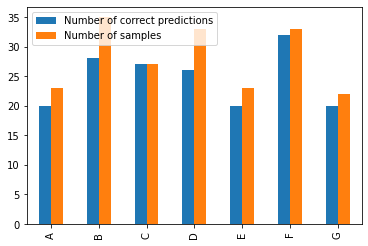

In [31]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [33]:
print(confusion_matrix(y_true, preds))

[[20  0  1  0  1  1  0]
 [ 1 28  0  1  0  4  1]
 [ 0  0 27  0  0  0  0]
 [ 3  0  1 26  0  3  0]
 [ 1  0  0  1 20  1  0]
 [ 1  0  0  0  0 32  0]
 [ 0  0  1  0  0  1 20]]


In [34]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.8826530612244898

In [35]:
with open(f'{results_dir}{dataset_str}{pretrained_str}_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [36]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.76923077, 1.        , 0.9       , 0.92857143, 0.95238095,
       0.76190476, 0.95238095])

In [37]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.86956522, 0.8       , 1.        , 0.78787879, 0.86956522,
       0.96969697, 0.90909091])

In [38]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.81632653, 0.88888889, 0.94736842, 0.85245902, 0.90909091,
       0.85333333, 0.93023256])

In [39]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(f'{results_dir}{dataset_str}{pretrained_str}_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.769231,0.869565,0.816327
B,1.000000,0.800000,0.888889
C,0.900000,1.000000,0.947368
D,0.928571,0.787879,0.852459
E,0.952381,0.869565,0.909091
F,0.761905,0.969697,0.853333
G,0.952381,0.909091,0.930233


<AxesSubplot:>

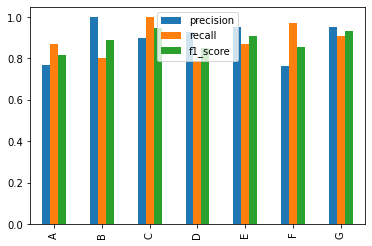

In [40]:
df.plot.bar()